# My First Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/getting_started/my_first_model.ipynb)


This guide will walk you through creating and training your first simulation-based inference model using GenSBI. We will cover the essential steps, from defining a simulator to training a neural density estimator.

As a frist step, make sure gensbi is installed in your environment. If you haven't done so yet, please refer to the [Installation Guide](/getting_started/installation) before proceeding, or simply run:

In [ ]:
# step 1: install packages
%pip install "GenSBI[cuda12,examples,validation] @ git+https://github.com/aurelio-amerio/GenSBI.git" --extra-index-url https://download.pytorch.org/whl/cpu

> **Important**: <br><br>
> If you are using Colab, restart the runtime after installation to ensure all packages are properly loaded. <br>

Next it is convenient to download the GenSBI-examples package, which contains several example notebooks and checkpoints, including this one. You can do so by running:

In [1]:
# step 2: clone the examples repository
!git clone https://github.com/aurelio-amerio/GenSBI-examples.git

Cloning into 'GenSBI-examples'...
remote: Enumerating objects: 3702, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3702 (delta 6), reused 0 (delta 0), pack-reused 3694 (from 1)
Receiving objects: 100% (3702/3702), 584.32 MiB | 24.15 MiB/s, done.
Resolving deltas: 100% (1493/1493), done.


In [1]:
# step 3: cd into the examples folder
# %cd GenSBI-examples
%cd /home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/getting_started/GenSBI-examples

/home/zaldivar/Documents/Aurelio/Github/GenSBI-examples/examples/getting_started/GenSBI-examples


Then we need to import all the necessary modules from GenSBI and other libraries. If you don't have a gpu available, you can set the device to "cpu" instead of "cuda", but training will be slower.

If you are getting some errors relating to missing packages, restart the notebook kernel, and run step 3 again.

In [2]:
import os

# Set JAX backend (use 'cuda' for GPU, 'cpu' otherwise)
# os.environ["JAX_PLATFORMS"] = "cuda"

import grain
import numpy as np
import jax
from jax import numpy as jnp
from numpyro import distributions as dist
from flax import nnx

from gensbi.recipes import Flux1FlowPipeline
from gensbi.models import Flux1Params

from gensbi.utils.plotting import plot_marginals
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0)

W1230 16:08:01.820948 1254900 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1230 16:08:01.827194 1254737 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


## The simulator

 The first step in simulation-based inference is to define a simulator function that generates data given parameters. In this example, we will create a simple simulator that generates data from a Gaussian distribution with a mean defined by the parameters.

The simulator takes in 3 parameters (theta) and returns 3 observations (xs). 

In the context of posterior density estimation, the `theta` parameters are the observations (what we want to model) and the `xs` are the conditions (the data we condition on, which we use to detemrine `theta`).

In [3]:
dim_obs = 3 # dimension of the observation (theta), that is the simulator input shape
dim_cond = 3 # dimension of the condition (xs), that is the simulator output shape
dim_joint = dim_obs + dim_cond # dimension of the joint (theta, xs), useful later

def _simulator(key, thetas):

    xs = thetas + 1 + jax.random.normal(key, thetas.shape) * 0.1

    thetas = thetas[..., None]
    xs = xs[..., None]

    # when making a dataset for the joint pipeline, thetas need to come first
    data = jnp.concatenate([thetas, xs], axis=1)

    return data

Now we define a prior distribution over the parameters. For simplicity, we will use a uniform prior over a specified range.

In [4]:
theta_prior = dist.Uniform(
    low=jnp.array([-2.0, -2.0, -2.0]), high=jnp.array([2.0, 2.0, 2.0])
)

For simpliciy, we define a simulator which samples from the prior internally.

In [5]:
def simulator(key, nsamples):
    theta_key, sample_key = jax.random.split(key, 2)
    thetas = theta_prior.sample(theta_key, (nsamples,))

    return _simulator(sample_key, thetas)

## The dataset

We create a dataset by running the simulator multiple times with parameters sampled from the prior distribution. This dataset will be used to train the neural density estimator.

GenSBI can work with any dataset that provides an iterator to obtain couples of (parameters, observations). 
For numerical efficiency and ease of use, it is convenient to create a Jax-based datset using `grain`, for high efficiency data-loading and prefetching.

In [6]:
# Define your training and validation datasets.
train_data = simulator(jax.random.PRNGKey(0), 10_000)
val_data = simulator(jax.random.PRNGKey(1), 2000)

In [7]:
# utility function to split data into observations and conditions
def split_obs_cond(data):
    return data[:, :dim_obs], data[:, dim_obs:]  # assuming first dim_obs are obs, last dim_cond are cond

We create a grain dataset with batch size = 128. The larger the batch size, the more stable the training.

Adjust according to your hardware capabilities, e.g. GPU memory (try experimenting with 256, 512, 1024, etc).


In [8]:
batch_size = 128

train_dataset_grain = (
    grain.MapDataset.source(np.array(train_data))
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(batch_size)
    .map(split_obs_cond)
    .mp_prefetch() # If you use prefetching in a .py script, make sure your python script is thread safe, see https://docs.python.org/3/library/multiprocessing.html
)

val_dataset_grain = (
    grain.MapDataset.source(np.array(val_data))
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(batch_size)
    .map(split_obs_cond)
    .mp_prefetch() 
)

These datasets are innfinite dataloaders, meaning that they will keep providing data as long as needed.
You can get samples from the dataset using:

In [9]:
iter_dataset = iter(train_dataset_grain)
obs,cond = next(iter_dataset)  # returns a batch of (observations, conditions)
print(obs.shape, cond.shape)  # should print (batch_size, dim_obs, 1), (batch_size, dim_cond, 1)

(128, 3, 1) (128, 3, 1)


## The Model

We define a `Flux1` model and pipeline. `Flux1` is a versatile transformer-based architecture suitable for various (complex) SBI tasks. Although for this problem a simpler architecture would suffice, we use `Flux1` to illustrate how to set up the main components of a GenSBI model.

In [58]:
# define the model parameters
params = Flux1Params(
    in_channels=1, # each observation/condition feature has only one channel (the value itself)
    vec_in_dim=None,
    context_in_dim=1, 
    mlp_ratio=3, # default value
    num_heads=2, # number of transformer heads
    depth=4, # number of double-stream transformer blocks
    depth_single_blocks=8, # number of single-stream transformer blocks
    axes_dim=[ 10,], # number of features per transformer head
    qkv_bias=True, # default
    dim_obs=dim_obs, # dimension of the observation (theta)
    dim_cond=dim_cond, # dimension of the condition (xs)
    theta=60, # dimension of the ROPE embedding space. A good rule of thumb is to set it to 10 times the joint dimension
    rngs=nnx.Rngs(default=42), # random number generator seed
    param_dtype=jnp.float32, # data type of the model parameters. 
)

For the sake of running this example, we will 

In [59]:
# checkpoint_dir = os.path.join(os.getcwd(), "examples/getting_started/checkpoints")
checkpoint_dir = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/getting_started/checkpoints"

training_config = Flux1FlowPipeline._get_default_training_config()
training_config["checkpoint_dir"] = checkpoint_dir
training_config["experiment_id"] = 3

In [60]:
checkpoint_dir

'/home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/getting_started/checkpoints'

In [61]:
# Intantiate the pipeline
pipeline = Flux1FlowPipeline(
    train_dataset_grain,
    val_dataset_grain,
    dim_obs,
    dim_cond,
    params=params,
    training_config=training_config,
)

## Training

Now we train the model using the defined pipeline. We specify the number of epochs and the random seed for reproducibility.

In [20]:
rngs = nnx.Rngs(42)

In [35]:
# uncomment to train the model
loss_history = pipeline.train(
    rngs, nsteps=5000, save_model=True
)  # if you want to save the model, set save_model=True

100%|██████████| 5000/5000 [20:41<00:00,  4.03it/s, counter=0, loss=0.1516, ratio=0.6254, val_loss=0.0948]


Saved model to checkpoint


If you don't want to waste time retraining the model, you can directly load a pre-trained model for this example using this code:

In [62]:
pipeline.restore_model(1)

Restored model from checkpoint


## Sampling from the posterior

In order to sample from the posterior distribution given new observations, we use the trained model's `sample` method. We provide the observation for which we want to reconstruct the posterior, and specify the number of samples we want to draw from the posterior.

In [37]:
new_sample = simulator(jax.random.PRNGKey(20), 1) # the observation for which we want to reconstruct the posterior

true_theta = new_sample[:, :dim_obs, :]  # The input used for the simulation, AKA the true value
x_o = new_sample[:, dim_obs:, :]  # The observation from the simulation for which we want to reconstruct the posterior

Now we sample from the posterior:

In [38]:
samples = pipeline.sample(rngs.sample(), x_o, nsamples=100_000)

Once we have the samples, we display the marginal distributions:

<Figure size 640x480 with 0 Axes>

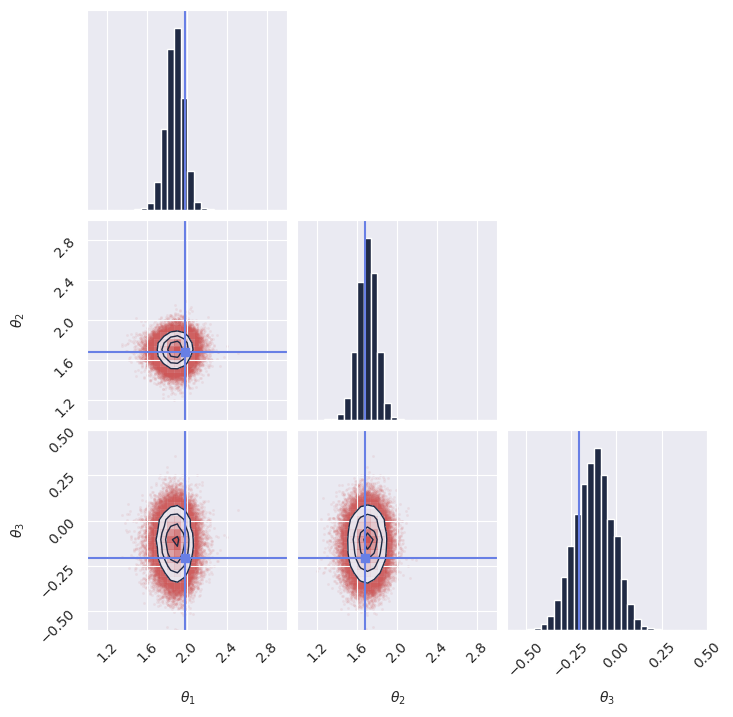

In [39]:
plot_marginals(
    np.array(samples[..., 0]), gridsize=30, true_param=np.array(true_theta[0, :, 0]), range = [(1, 3), (1, 3), (-0.6, 0.5)]
)
# plt.savefig("flux1_flow_pipeline_marginals.png", dpi=100, bbox_inches="tight") # uncomment to save the figure
plt.show()

![flux1_flow_pipeline_marginals.png](https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/getting_started/flux1_flow_pipeline_marginals.png)

## Next steps

Congratulations! You have successfully created and trained your first simulation-based inference model using GenSBI. You can now experiment with different simulators, priors, and neural density estimators to explore more complex inference tasks.

For more examples, please refer to the [Examples Section](/examples) of the GenSBI documentation.

As a step forward, you might want to explore how to validate the performance of your trained model using techniques such as simulation-based calibration (SBC) or coverage plots. These methods help assess the quality of the inferred posterior distributions and ensure that your model is providing accurate uncertainty estimates.

## Posterior calibration tests

In this section we perform posterior calibration tests using Simulation-Based Calibration (SBC), Targeted At Random Parameters (TARP) and L-C2ST methods to evaluate the quality of our trained model's posterior estimates.

GenSBI does not provide built-in functions for SBC and TARP, but we can leverage the `sbi` package to perform these tests. GenSBI includes a compatibility layer that allows us to use `sbi`'s validation tools seamlessly with GenSBI models.
In order to install `sbi`, as well as the compatibility layer, we use the `validation` submodule.

The following section demonstrates how to perform these posterior calibration tests using the `sbi` package in conjunction with our trained GenSBI model, and it draws strong inspiration from the `sbi` documentation.

> **Note:** When rerunning this notebook, the plots for the folllowing tests may differ slightly due to the stochastic nature of the sampling process. In jax, random number generation is based on explicit random keys, while in torch it relies on a global random state, making it harder to enforce consistency across different runs. Due to this nature, it is not possible to explicitly set the random seed for sampling in the compatibility layer, beside at initialization time. However, the overall trends and conclusions drawn from the tests should remain consistent across different runs.

For a full overiew of posterior calibration tests, refer to the [sbi documentation](https://sbi.readthedocs.io/en/latest/how_to_guide.html#diagnosticsl). 

In [40]:
# imports
from gensbi_validation import PosteriorWrapper
from sbi.analysis.plot import sbc_rank_plot
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp
from sbi.analysis.plot import plot_tarp

import torch

We wrap the pipeline posterior into a `PosteriorWrapper`, which provides an interface compatible with `sbi`.

In [41]:
posterior = PosteriorWrapper(pipeline, rngs=nnx.Rngs(1234))

We sample 200 new observations from the simulator to perform the calibration tests.
It is instrumental that we use a seed different from the one used during training to avoid biased results.

In [42]:
key = jax.random.PRNGKey(1234)
# sample the dataset
test_data = simulator(jax.random.PRNGKey(1), 200)

# split in thetas and xs
thetas = test_data[:, :dim_obs, :] # (200, 3, 1)
xs = test_data[:, dim_obs:, :] # (200, 3, 1)

# flatten the dataset. sbi expects 2D arrays of shape (num_samples, features), while our data is 3D of shape (num_samples, dim, channels).
# we reshape a sample of size (dim, channels) into a vector of size (dim * channels)
thetas = posterior._ravel(thetas) # (200, 3)
xs = posterior._ravel(xs) # (200, 3)

# convert to torch tensors
thetas = torch.Tensor(np.array(thetas))
xs = torch.Tensor(np.array(xs))

### SBC

SBC allows you to evaluate whether individual marginals of the posterior are, on average across many observations (prior predictive samples) too narrow, too wide, or skewed.

In [43]:
ranks, dap_samples = run_sbc(thetas, xs, posterior)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)

Sampling: 100%|██████████| 20/20 [02:43<00:00,  8.17s/it]


Calculating ranks for 200 SBC samples:   0%|          | 0/200 [00:00<?, ?it/s]

In [44]:
print(check_stats)

{'ks_pvals': tensor([0.0077, 0.0791, 0.3164]), 'c2st_ranks': tensor([0.5125, 0.5625, 0.5225], dtype=torch.float64), 'c2st_dap': tensor([0.4525, 0.4975, 0.5125], dtype=torch.float64)}


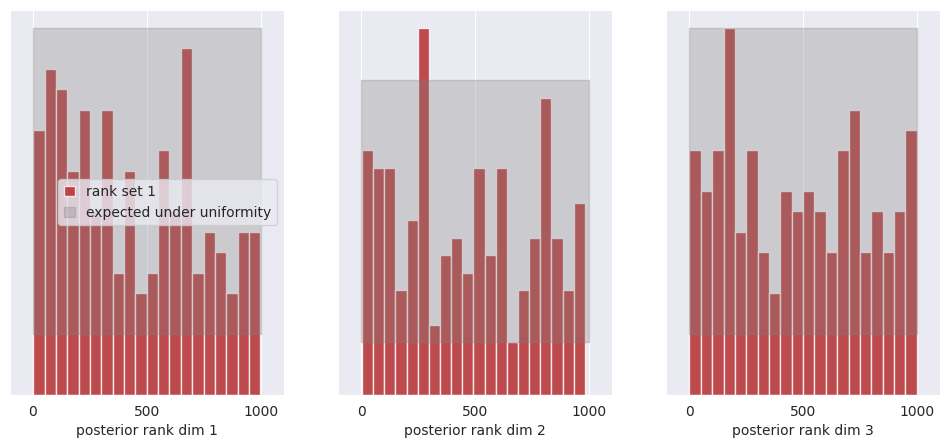

In [45]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="hist", num_bins=20)
# plt.savefig("flux1_flow_pipeline_sbc.png", dpi=100, bbox_inches="tight") # uncomment to save the figure
plt.show()

![flux1_flow_pipeline_sbc.png](https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/getting_started/flux1_flow_pipeline_sbc.png)

All of the bars fall within the expected uniform distribution, thus we cannot reject the hypothesis that the posterior marginals are calibrated.

See the SBI tutorial [https://sbi.readthedocs.io/en/latest/how_to_guide/16_sbc.html](https://sbi.readthedocs.io/en/latest/how_to_guide/16_sbc.html) for more details on SBC.

### TARP

TARP is an alternative calibration check proposed recently in https://arxiv.org/abs/2302.03026.

In [46]:
ecp, alpha = run_tarp(
    thetas,
    xs,
    posterior,
    references=None,  # will be calculated automatically.
    num_posterior_samples=10000, # reduce this number to 1000 if you go OOM
)

Sampling: 100%|██████████| 200/200 [24:54<00:00,  7.47s/it]


In [47]:
atc, ks_pval = check_tarp(ecp, alpha)
print(atc, "Should be close to 0")
print(ks_pval, "Should be larger than 0.05")

0.31259885430336 Should be close to 0
0.9999999953860058 Should be larger than 0.05


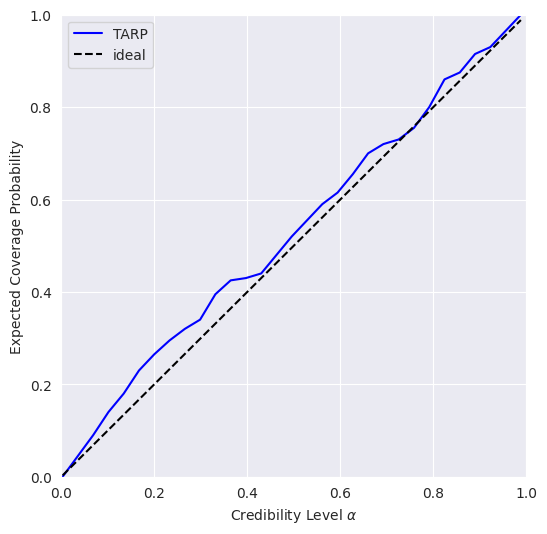

In [48]:
plot_tarp(ecp, alpha)
# plt.savefig("flux1_flow_pipeline_tarp.png", dpi=100, bbox_inches="tight") # uncomment to save the figure
plt.show()

![flux1_flow_pipeline_tarp.png](https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/getting_started/flux1_flow_pipeline_tarp.png)

If the blue curve is above the diagonal, then the posterior estimate is under-confident. If it is under the diagonal, then the posterior estimate is over confident.

This means that our model is slightly under-confident. 

See [https://sbi.readthedocs.io/en/latest/how_to_guide/17_tarp.html](https://sbi.readthedocs.io/en/latest/how_to_guide/17_tarp.html) for more details on TARP.

### L-C2ST

Tests like expected coverage and simulation-based calibration evaluate whether the posterior is on average across many observations well-calibrated. Unlike these tools, L-C2ST allows you to evaluate whether the posterior is correct for a specific observation.

In [49]:
# Simulate calibration data. Should be at least in the thousands.

key = jax.random.PRNGKey(1234)
# sample the dataset
test_data = simulator(jax.random.PRNGKey(1), 10_000)

# split in thetas and xs
thetas = test_data[:, :dim_obs, :] # (10_000, 3, 1)
xs = test_data[:, dim_obs:, :] # (10_000, 3, 1)

# flatten the dataset. sbi expects 2D arrays of shape (num_samples, features), while our data is 3D of shape (num_samples, dim, channels).
# we reshape a sample of size (dim, channels) into a vector of size (dim * channels)
thetas = posterior._ravel(thetas) # (10_000, 3)
xs = posterior._ravel(xs) # (10_000, 3)

# convert to torch tensors
thetas = torch.Tensor(np.array(thetas))
xs = torch.Tensor(np.array(xs))

In [50]:
# Generate one posterior sample for every prior predictive.
posterior_samples = posterior.sample_batched(
    (1,),
    x=xs,
)[0]

Sampling: 100%|██████████| 1/1 [00:20<00:00, 20.43s/it]


In [51]:
from sbi.diagnostics.lc2st import LC2ST


# Train the L-C2ST classifier.
lc2st = LC2ST(
    thetas=thetas,
    xs=xs,
    posterior_samples=posterior_samples,
    classifier="mlp",
    num_ensemble=1,
)
_ = lc2st.train_under_null_hypothesis()
_ = lc2st.train_on_observed_data()

Training the classifiers under H0, permutation = True: 100%|██████████| 100/100 [06:44<00:00,  4.05s/it]


In [52]:
key = jax.random.PRNGKey(12345)

sample = simulator(key, 1)
theta_true = sample[:, :dim_obs, :]  
x_o = sample[:, dim_obs:, :]  

# Note: x_o must have a batch-dimension. I.e. `x_o.shape == (1, observation_shape)`.
post_samples_star = pipeline.sample(key, x_o, nsamples=10_000) 

post_samples_star = np.array(post_samples_star.reshape(-1, dim_obs))

In [53]:
post_samples_star_torch = torch.Tensor(np.array(post_samples_star.reshape(-1, dim_obs)))
x_o_torch = torch.Tensor(np.array(x_o.reshape(-1, dim_cond)))

In [54]:
probs_data, scores_data = lc2st.get_scores(
    theta_o=post_samples_star_torch,
    x_o=x_o_torch,
    return_probs=True,
    trained_clfs=lc2st.trained_clfs
)
probs_null, scores_null = lc2st.get_statistics_under_null_hypothesis(
    theta_o=post_samples_star_torch,
    x_o=x_o_torch,
    return_probs=True,
)

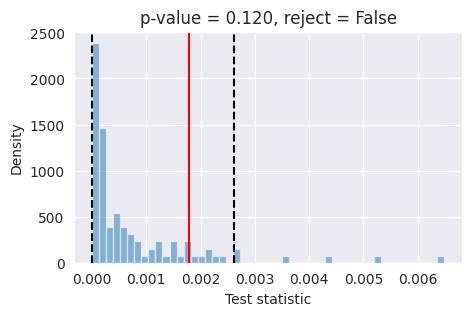

In [55]:
conf_alpha = 0.05
p_value = lc2st.p_value(post_samples_star_torch, x_o_torch)
reject = lc2st.reject_test(post_samples_star_torch, x_o_torch, alpha=conf_alpha)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
quantiles = np.quantile(scores_null, [0, 1-conf_alpha])
ax.hist(scores_null, bins=50, density=True, alpha=0.5, label="Null")
ax.axvline(scores_data, color="red", label="Observed")
ax.axvline(quantiles[0], color="black", linestyle="--", label="95% CI")
ax.axvline(quantiles[1], color="black", linestyle="--")
ax.set_xlabel("Test statistic")
ax.set_ylabel("Density")
ax.set_title(f"p-value = {p_value:.3f}, reject = {reject}")
# plt.savefig("flux1_flow_pipeline_lc2st.png", dpi=100, bbox_inches="tight") # uncomment to save the figure
plt.show()

![flux1_flow_pipeline_lc2st.png](https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/getting_started/flux1_flow_pipeline_lc2st.png)

If the red bar falls outside the two dashed black lines, it indicates that the model's posterior estimates are not well-calibrated at the 95% confidence level and further investigation is required.

### Conclusions

What happened? As it turns out, our simple model trained on a small dataset is not always able to provide well-calibrated posterior estimates. This is because the model was trained on a limited number of simulations with a small batch size and for a short duration. To improve the accuracy of the posterior estimates, it is necessary to train the model with a larger batch size (around `1024` or more) and for a longer period (around `50_000` training steps).

The `Flux1` architecture is quite powerful and flexible, but being transformer based requires a longer training time and greatly benefits from larger datasets and large batch sizes to avoid overfitting the training dataset.

As an experiment, we retrained the model with a batch size of `1024` for `50_000` training steps, and obtained much better results in terms of posterior calibration. For reference, we provide the pre-trained model checkpoint and training configuration to load directly without retraining.

In [57]:
checkpoint_dir = os.path.join(os.getcwd(), "examples/getting_started/checkpoints")

config_path = os.path.join(
    os.getcwd(), "examples/getting_started/config_flow_flux.yaml"
)

pipeline = Flux1FlowPipeline.init_pipeline_from_config(
        train_dataset_grain,
        val_dataset_grain,
        dim_obs,
        dim_cond,
        config_path,
        checkpoint_dir,
    )

pipeline.restore_model(1)

ValueError: User-provided restore item and on-disk value metadata tree structures do not match:
double_blocks.layers.4:
    - Source: {'cond_attn': {'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}, 'proj': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.29742694, -0.36210456,  0.04130339, ..., -0.02731416,
        -0.01237277,  0.15188491],
       [ 0.06423729, -0.01731776, -0.02944442, ...,  0.13437547,
         0.19086061, -0.04079152],
       [ 0.199139  , -0.15723896, -0.15007344, ..., -0.10434972,
         0.00608698, -0.19984162],
       ...,
       [-0.05822955, -0.04232303,  0.04940425, ...,  0.26202258,
         0.20987742, -0.21509409],
       [-0.15225703,  0.05152256, -0.07487541, ..., -0.10870412,
        -0.25434905,  0.08945901],
       [ 0.1657448 ,  0.00886645,  0.16235635, ..., -0.02140977,
         0.15795268,  0.23576294]], dtype=float32)}}, 'qkv': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.28414527,  0.03321551,  0.09119812, ..., -0.10208069,
         0.02333031,  0.3089948 ],
       [-0.15037964, -0.23298581,  0.07879663, ..., -0.06747188,
        -0.15607354, -0.35581094],
       [ 0.02073133,  0.17750736,  0.22178169, ..., -0.2301951 ,
        -0.09953489,  0.15575038],
       ...,
       [ 0.16297446,  0.06482806,  0.02189184, ...,  0.09955288,
        -0.08779901, -0.00144492],
       [ 0.00068747,  0.19282793,  0.03865519, ..., -0.14181371,
        -0.2665898 , -0.06113148],
       [ 0.1531788 ,  0.22347306, -0.2142487 , ..., -0.14262494,
        -0.309668  ,  0.1335452 ]], dtype=float32)}}}, 'cond_mlp': {'layers': {'0': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.22192746, -0.37571454, -0.08458629, ..., -0.17803968,
         0.2573605 ,  0.07228193],
       [-0.05063391, -0.19810887,  0.09078541, ...,  0.08565485,
        -0.20153068, -0.22641125],
       [-0.32908067,  0.0671759 ,  0.1017824 , ...,  0.21740189,
        -0.09764527, -0.04031982],
       ...,
       [ 0.29593307, -0.05716213, -0.04893732, ..., -0.29579154,
         0.2763828 , -0.01857999],
       [ 0.16228187, -0.02702658, -0.17554078, ...,  0.07940889,
         0.06346018, -0.15962537],
       [ 0.15845709,  0.06588937, -0.04216972, ..., -0.07013635,
        -0.13634783,  0.11671386]], dtype=float32)}}, '2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.03958369, -0.01647242, -0.12105289, ..., -0.02527568,
        -0.12890153, -0.09707152],
       [ 0.11909555,  0.01672401,  0.07881754, ..., -0.01904826,
        -0.1104375 ,  0.10336041],
       [-0.0261372 , -0.02361084,  0.00847458, ...,  0.01826284,
         0.10113718, -0.02699427],
       ...,
       [-0.0583978 , -0.034212  , -0.06650198, ...,  0.02265605,
         0.05813927,  0.04177158],
       [-0.10118201, -0.00312889, -0.0907332 , ...,  0.0242414 ,
         0.09219903,  0.07600453],
       [-0.09864546,  0.12461524,  0.02380252, ...,  0.00640181,
         0.05274298,  0.10308987]], dtype=float32)}}}}, 'cond_mod': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'obs_attn': {'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}, 'proj': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.12425802, -0.17528263, -0.30998608, ..., -0.00413498,
         0.0578584 ,  0.02379016],
       [ 0.11986679,  0.05681977, -0.02504251, ..., -0.14509596,
        -0.351241  ,  0.14996928],
       [-0.07537945, -0.07215471, -0.2577177 , ..., -0.0594997 ,
        -0.23719507,  0.02354114],
       ...,
       [ 0.21344885,  0.25741285,  0.039381  , ...,  0.150834  ,
         0.06861789,  0.0568933 ],
       [-0.10097007, -0.08812469,  0.00959208, ...,  0.00123383,
        -0.08262445, -0.32179305],
       [ 0.128494  , -0.0509962 ,  0.08325201, ..., -0.03626617,
         0.07127386,  0.02885463]], dtype=float32)}}, 'qkv': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.08243687,  0.00703803,  0.20479475, ..., -0.00320135,
        -0.19929324,  0.3223807 ],
       [-0.21356124,  0.29617047,  0.01553766, ..., -0.03268717,
        -0.25775424,  0.06857681],
       [-0.06674148, -0.25158846,  0.17576136, ..., -0.29608122,
         0.3696119 , -0.06779701],
       ...,
       [ 0.01985848, -0.20543209,  0.1924482 , ..., -0.06634716,
         0.04134676,  0.21097337],
       [ 0.1334593 , -0.09944496, -0.01358679, ...,  0.29577455,
         0.18278296, -0.1035651 ],
       [-0.17453432,  0.0323836 , -0.05962524, ..., -0.1777625 ,
        -0.05511138,  0.02987623]], dtype=float32)}}}, 'obs_mlp': {'layers': {'0': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.27372107, -0.09502417,  0.04032396, ..., -0.28001854,
        -0.02428123,  0.02953949],
       [ 0.10662443,  0.04241269, -0.3533855 , ...,  0.2883927 ,
        -0.00682437,  0.31160447],
       [-0.1252121 , -0.12057874,  0.16158566, ...,  0.16806589,
         0.25286236,  0.28797874],
       ...,
       [ 0.27597174,  0.10307958, -0.3568741 , ...,  0.12268837,
         0.18339658, -0.14378436],
       [ 0.12932439,  0.11452537,  0.3243654 , ...,  0.3019402 ,
        -0.03430216, -0.2801215 ],
       [-0.17096488, -0.19073534,  0.00650456, ..., -0.26175955,
        -0.00411915, -0.05941398]], dtype=float32)}}, '2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.04171921, -0.02458551,  0.08883623, ...,  0.15223394,
        -0.12608327, -0.05714911],
       [ 0.0296493 , -0.14411145, -0.0259291 , ..., -0.17395113,
        -0.09931716,  0.04985748],
       [-0.03128221, -0.03622892,  0.12828466, ..., -0.07681201,
        -0.0634582 , -0.0744957 ],
       ...,
       [ 0.09415708, -0.13590294, -0.00892092, ..., -0.09186971,
         0.05293422,  0.12908927],
       [-0.02423004, -0.09722906,  0.06281397, ...,  0.00510244,
        -0.00703289,  0.08162162],
       [ 0.12320337, -0.05380533, -0.08138058, ...,  0.00828166,
        -0.02239683,  0.03976234]], dtype=float32)}}}}, 'obs_mod': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}}
    - Target: MISSING

double_blocks.layers.5:
    - Source: {'cond_attn': {'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}, 'proj': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.08278482,  0.15772744,  0.08943369, ..., -0.3354496 ,
        -0.1591253 ,  0.13379239],
       [-0.2961685 , -0.06957309,  0.30637074, ..., -0.06903267,
         0.12193564,  0.10037652],
       [ 0.21997131,  0.01968895,  0.10594741, ..., -0.06490126,
        -0.18957457,  0.014232  ],
       ...,
       [ 0.0548185 ,  0.10050023,  0.2339728 , ..., -0.05308022,
         0.3756357 , -0.09008072],
       [ 0.01866221,  0.17635387,  0.19622616, ...,  0.37351045,
        -0.04992288,  0.06329343],
       [ 0.12022149, -0.04363914,  0.0054518 , ..., -0.13914105,
        -0.36720955,  0.1583859 ]], dtype=float32)}}, 'qkv': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.17673767,  0.05790082,  0.17685811, ..., -0.06302464,
        -0.14366189, -0.06062122],
       [ 0.04799567, -0.26293635, -0.00141353, ..., -0.05559747,
         0.02476367,  0.05995276],
       [-0.06271777, -0.04159182, -0.11294911, ...,  0.00563881,
        -0.01653923, -0.14788799],
       ...,
       [-0.0458714 ,  0.06187451, -0.03191807, ..., -0.12803598,
         0.09783484, -0.06381871],
       [ 0.11502667,  0.23107742, -0.15832834, ...,  0.15104702,
         0.04257378, -0.0777894 ],
       [ 0.14712496, -0.06749607, -0.04590597, ...,  0.01898524,
        -0.21833245, -0.12716648]], dtype=float32)}}}, 'cond_mlp': {'layers': {'0': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.18324338,  0.20717339,  0.1649022 , ..., -0.0267716 ,
         0.04055028, -0.23431551],
       [-0.34757444,  0.24512361,  0.08014926, ...,  0.30292544,
         0.21575318,  0.16019934],
       [-0.13968422, -0.14348608,  0.23528169, ...,  0.03120533,
         0.00828194,  0.20551595],
       ...,
       [-0.19084866, -0.12876837, -0.05463614, ..., -0.09898133,
         0.13165359, -0.18935695],
       [ 0.07326598, -0.0230506 ,  0.25211903, ...,  0.19922173,
         0.14046979,  0.23753975],
       [ 0.00943629,  0.10502893,  0.0752756 , ..., -0.06700932,
        -0.04126392, -0.21129505]], dtype=float32)}}, '2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.02601515, -0.11680249, -0.03110047, ..., -0.06200996,
        -0.02722293,  0.03233352],
       [ 0.02796953,  0.0157241 ,  0.00821995, ..., -0.15526214,
        -0.02483918,  0.06650292],
       [-0.02047467,  0.034694  ,  0.09372333, ...,  0.04314047,
        -0.02553259, -0.03234793],
       ...,
       [-0.03121656,  0.06886891,  0.03277432, ...,  0.02000277,
        -0.05322158,  0.06497539],
       [-0.03656284, -0.01378086,  0.13351849, ..., -0.06960266,
        -0.13992326, -0.08503505],
       [ 0.11499651,  0.02409684, -0.00251254, ..., -0.07707436,
        -0.13704784,  0.07504763]], dtype=float32)}}}}, 'cond_mod': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'obs_attn': {'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}, 'proj': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.09747492, -0.23274557, -0.05287472, ...,  0.00493292,
        -0.334982  , -0.0592293 ],
       [ 0.0289549 ,  0.28874424, -0.1900363 , ...,  0.11490348,
         0.02038364,  0.25380802],
       [ 0.26897737, -0.08748458, -0.16448337, ...,  0.06068077,
        -0.13689469,  0.13800062],
       ...,
       [ 0.14550151,  0.02668427,  0.19215214, ..., -0.08571111,
        -0.10369588, -0.08908455],
       [-0.17532466, -0.1882543 ,  0.02756471, ...,  0.1570909 ,
         0.37763652, -0.12990047],
       [ 0.02959293, -0.1542691 ,  0.14641255, ...,  0.00481663,
        -0.27156523, -0.09896194]], dtype=float32)}}, 'qkv': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.26046422,  0.05992384,  0.28381166, ...,  0.34541026,
         0.17688191, -0.03678942],
       [-0.10261657,  0.23375626,  0.01655717, ...,  0.09016412,
        -0.23752482, -0.05978181],
       [-0.08639286,  0.21064323,  0.11174301, ...,  0.14802492,
         0.00339457,  0.13966368],
       ...,
       [-0.3026501 ,  0.1808814 ,  0.1169628 , ..., -0.11454361,
         0.02875618,  0.03307486],
       [-0.05257317, -0.11827645,  0.22074753, ..., -0.14399628,
         0.01941821, -0.0038466 ],
       [-0.11982963, -0.16655688, -0.10818396, ...,  0.12015277,
        -0.00696795,  0.04408065]], dtype=float32)}}}, 'obs_mlp': {'layers': {'0': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.24878062, -0.01592089, -0.01263538, ...,  0.17604192,
         0.21140063, -0.13145216],
       [-0.24579938, -0.16258284, -0.30982587, ..., -0.10215443,
         0.12079416,  0.35953295],
       [-0.00896438,  0.08692786, -0.34387246, ..., -0.18528895,
         0.03269132,  0.1316715 ],
       ...,
       [ 0.10823995, -0.04057679, -0.09109085, ...,  0.36746955,
         0.17110199, -0.13084878],
       [-0.11950005, -0.19967711, -0.07554936, ..., -0.10409458,
         0.0699512 ,  0.12236531],
       [-0.2868689 ,  0.2689368 ,  0.21737072, ..., -0.07607797,
         0.11328068, -0.01496491]], dtype=float32)}}, '2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.03640886, -0.02536804, -0.13264038, ...,  0.02525365,
         0.08943111,  0.11118072],
       [ 0.05700319, -0.00769048,  0.00462746, ...,  0.06262236,
         0.13586351,  0.06685504],
       [ 0.12079491, -0.13930544, -0.12221144, ...,  0.03074424,
         0.05778478, -0.1249756 ],
       ...,
       [-0.06292713, -0.01784286,  0.09314672, ..., -0.07940847,
         0.15376599,  0.11641487],
       [-0.04598204, -0.02968567, -0.04851246, ...,  0.03373462,
         0.0575171 ,  0.11608785],
       [-0.18481249,  0.02001902,  0.04901245, ...,  0.02600093,
         0.00194084,  0.0055289 ]], dtype=float32)}}}}, 'obs_mod': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}}
    - Target: MISSING

double_blocks.layers.6:
    - Source: {'cond_attn': {'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}, 'proj': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 7.6450057e-02,  2.9033658e-01, -6.6041723e-03, ...,
        -9.1402963e-02,  7.9172077e-03, -1.8442045e-01],
       [-1.7763093e-01,  3.0516852e-02,  3.2413214e-02, ...,
         1.4995667e-01, -4.4087232e-03,  6.2049899e-02],
       [-7.7058934e-02,  1.3914825e-01, -1.3597506e-01, ...,
        -1.0460849e-03, -4.5371119e-02,  3.2909226e-02],
       ...,
       [ 1.0920898e-02, -3.5971880e-01,  3.7968419e-02, ...,
        -1.3788792e-01, -2.6665786e-01, -4.7899284e-03],
       [-9.9777050e-02,  6.4469948e-02, -2.1461481e-01, ...,
         6.7631468e-02, -8.2114108e-02,  3.0989832e-01],
       [-4.6426368e-05, -3.3051696e-01,  1.9531935e-01, ...,
        -9.5728107e-02, -6.4811468e-02,  3.7640799e-02]], dtype=float32)}}, 'qkv': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.04595717, -0.01409608,  0.08322661, ...,  0.1545397 ,
         0.18698819,  0.08012137],
       [ 0.07615902,  0.01776817, -0.35833013, ..., -0.01293621,
        -0.28387886,  0.15581906],
       [-0.2235976 , -0.03771702,  0.14811988, ...,  0.21835999,
         0.00293327, -0.22765476],
       ...,
       [ 0.04094165, -0.23701206,  0.30965215, ..., -0.23845264,
        -0.31687513, -0.13495044],
       [ 0.296338  , -0.08321727, -0.26269397, ..., -0.24227194,
        -0.02202828, -0.32391554],
       [ 0.06896465, -0.20676525, -0.01410481, ...,  0.17822717,
         0.06186409, -0.12593377]], dtype=float32)}}}, 'cond_mlp': {'layers': {'0': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.23053424, -0.36660662,  0.07040837, ..., -0.06895339,
         0.04600963,  0.04936946],
       [-0.12449472,  0.15826438,  0.01821315, ...,  0.03307118,
         0.10772065,  0.02212164],
       [ 0.12836064, -0.03169057,  0.30173993, ...,  0.05698077,
        -0.14666137, -0.09118427],
       ...,
       [-0.11300515,  0.11875034,  0.32946914, ..., -0.10239217,
        -0.0519831 , -0.15880996],
       [-0.199187  , -0.3221512 ,  0.01305277, ...,  0.0445958 ,
         0.11387389,  0.13829064],
       [-0.31446272,  0.13577135, -0.28186244, ...,  0.14183916,
         0.37312672, -0.26663795]], dtype=float32)}}, '2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.06963588,  0.06391943,  0.04452695, ...,  0.0932797 ,
        -0.07168777, -0.05774091],
       [ 0.00814957, -0.01938624,  0.07612318, ..., -0.05100607,
        -0.15371487,  0.09206641],
       [ 0.08581038,  0.00628988,  0.12906893, ...,  0.13400689,
         0.00563173, -0.14083005],
       ...,
       [-0.13953061,  0.02278854, -0.0164344 , ..., -0.011201  ,
         0.1543877 ,  0.13943979],
       [-0.02046891,  0.0499137 , -0.09326992, ..., -0.01866907,
         0.00715372,  0.06551959],
       [ 0.06768439,  0.03770182, -0.0393951 , ...,  0.06936731,
        -0.0219474 , -0.05297602]], dtype=float32)}}}}, 'cond_mod': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'obs_attn': {'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}, 'proj': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.1413761 , -0.00486081,  0.16818872, ..., -0.00281469,
         0.05853834,  0.11562104],
       [-0.34155676, -0.30702105, -0.07176765, ...,  0.24241139,
        -0.00759545, -0.22367735],
       [-0.15602286, -0.2284888 , -0.12695494, ..., -0.34073624,
         0.16453192,  0.11821143],
       ...,
       [ 0.07604693, -0.00056792, -0.00631159, ..., -0.19294187,
        -0.11776842, -0.00856962],
       [-0.01772075, -0.11862975,  0.12364276, ...,  0.19452246,
        -0.29616448,  0.22117963],
       [ 0.05686413,  0.01494117,  0.1252855 , ...,  0.05326455,
         0.08808104, -0.05238747]], dtype=float32)}}, 'qkv': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.254186  , -0.07304598,  0.03274261, ...,  0.14670797,
         0.10043667,  0.00394855],
       [ 0.17176177,  0.03306147, -0.30270338, ..., -0.20468655,
         0.3243416 , -0.10607406],
       [ 0.04519401,  0.09784015,  0.293298  , ..., -0.06641669,
         0.09872125, -0.25156447],
       ...,
       [-0.13149713, -0.15281387, -0.05041547, ...,  0.10372826,
        -0.0171421 ,  0.05637279],
       [ 0.03038723, -0.03520815,  0.04095171, ...,  0.07959306,
         0.13473506, -0.03859095],
       [-0.09767255, -0.34409288,  0.26566774, ..., -0.0008551 ,
        -0.04743994, -0.09775137]], dtype=float32)}}}, 'obs_mlp': {'layers': {'0': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.31569383, -0.16032323,  0.36928967, ...,  0.09100818,
        -0.04892435,  0.24388784],
       [ 0.03930128,  0.09406768, -0.03194488, ...,  0.0361592 ,
         0.17757633,  0.14923681],
       [ 0.17019325, -0.0387475 , -0.03010704, ...,  0.13218585,
         0.14017412, -0.06256054],
       ...,
       [-0.01692013,  0.04787536,  0.03234281, ..., -0.1959421 ,
        -0.10958857,  0.26959437],
       [-0.04079605,  0.16076013, -0.05411957, ...,  0.04085165,
         0.0776279 ,  0.16955747],
       [ 0.09033801,  0.09952538, -0.28613138, ...,  0.17079268,
         0.07786871,  0.01977462]], dtype=float32)}}, '2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.15792905, -0.06223462, -0.06964935, ...,  0.03327863,
        -0.00442168, -0.01333526],
       [ 0.02447459, -0.02323471,  0.07893323, ..., -0.15093571,
        -0.02288476, -0.12463243],
       [ 0.14456867, -0.00287095,  0.09285668, ...,  0.10489663,
         0.01424537, -0.10380652],
       ...,
       [ 0.02789071,  0.04093136, -0.10721733, ...,  0.02507537,
        -0.06893286, -0.11712739],
       [-0.04121246,  0.02588372,  0.12729456, ..., -0.01538267,
         0.11466865,  0.09155137],
       [ 0.05037696, -0.03926893,  0.08282764, ..., -0.00688475,
        -0.06407568, -0.01236189]], dtype=float32)}}}}, 'obs_mod': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}}
    - Target: MISSING

double_blocks.layers.7:
    - Source: {'cond_attn': {'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}, 'proj': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.15409863, -0.21534751, -0.01792978, ..., -0.23734659,
        -0.11200923,  0.09237827],
       [ 0.19556361,  0.2961969 ,  0.0101204 , ..., -0.21335392,
         0.2195061 , -0.03002578],
       [ 0.1681074 , -0.06646543,  0.24149576, ..., -0.22706626,
         0.14777182, -0.16776289],
       ...,
       [ 0.11437989,  0.11437323,  0.0518293 , ...,  0.00571526,
         0.07570143, -0.12203383],
       [ 0.1396206 ,  0.09659403,  0.22294152, ...,  0.03540549,
        -0.13106474,  0.0703968 ],
       [-0.33018517, -0.3515663 , -0.00118924, ..., -0.16865185,
         0.37700856,  0.00457305]], dtype=float32)}}, 'qkv': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.17638221, -0.15172035,  0.10127427, ..., -0.06362902,
         0.06630126,  0.14385185],
       [ 0.23253036, -0.15277484,  0.06327873, ...,  0.13545954,
        -0.12777656,  0.23307572],
       [-0.18023951,  0.2900277 , -0.07136529, ..., -0.11377323,
         0.11641223, -0.03033818],
       ...,
       [ 0.09169032,  0.15371178, -0.22205746, ...,  0.04497191,
         0.1801134 , -0.03415456],
       [-0.16737682, -0.05035182,  0.24707435, ..., -0.05297147,
        -0.23321778,  0.21375343],
       [ 0.240753  , -0.11206446,  0.3416698 , ..., -0.20610146,
        -0.21894449, -0.25572348]], dtype=float32)}}}, 'cond_mlp': {'layers': {'0': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.356827  , -0.24987216, -0.01405641, ...,  0.01276216,
         0.10851198,  0.18912145],
       [ 0.21608625,  0.08219682, -0.03803756, ...,  0.26699743,
         0.2573868 ,  0.01222085],
       [ 0.120149  , -0.03363723, -0.17481636, ..., -0.17560571,
        -0.11604026, -0.19654296],
       ...,
       [ 0.14411533, -0.09619028,  0.10784245, ..., -0.06972475,
        -0.26858577,  0.18915434],
       [ 0.14335589,  0.14115858, -0.1725169 , ...,  0.14405617,
         0.09813535, -0.10264648],
       [-0.04399504, -0.02532231, -0.04891319, ...,  0.1438959 ,
        -0.2693942 , -0.1628017 ]], dtype=float32)}}, '2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.02003377,  0.00327661,  0.00135873, ..., -0.07191067,
         0.02401278,  0.06665654],
       [ 0.14858733, -0.08355097, -0.08945516, ...,  0.04658763,
        -0.11000196,  0.11891712],
       [ 0.07801218,  0.08918158, -0.02494896, ..., -0.05131961,
         0.03004356, -0.05808702],
       ...,
       [-0.01305633, -0.02310867, -0.11858127, ...,  0.02530198,
         0.07448656, -0.16417976],
       [-0.04248007,  0.10993429,  0.00493781, ...,  0.11521951,
         0.10186473, -0.08755042],
       [ 0.01973114,  0.10654777, -0.10211985, ...,  0.02613851,
        -0.00655247, -0.03790513]], dtype=float32)}}}}, 'cond_mod': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'obs_attn': {'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}, 'proj': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.0421602 ,  0.03107925, -0.14909306, ...,  0.11083084,
         0.23235855, -0.02931058],
       [ 0.12615065, -0.12472001, -0.37410626, ...,  0.11531088,
         0.20644891,  0.31474653],
       [-0.13203369, -0.00209128,  0.09872287, ..., -0.19746698,
         0.15862718, -0.3018085 ],
       ...,
       [ 0.14316487,  0.21414024,  0.11931985, ..., -0.30649325,
        -0.17907278, -0.19784915],
       [ 0.05494604,  0.19125219, -0.03888823, ..., -0.03010387,
        -0.18654634,  0.11318118],
       [-0.17200628, -0.11314035, -0.22603197, ..., -0.0912419 ,
        -0.3319946 ,  0.01039582]], dtype=float32)}}, 'qkv': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.17626478, -0.0489362 , -0.03038241, ...,  0.03233864,
        -0.03850908,  0.07007726],
       [ 0.10580482,  0.2928076 , -0.20290427, ...,  0.01532544,
         0.06462505, -0.14317292],
       [ 0.1958811 , -0.0699965 , -0.02661976, ..., -0.09570282,
         0.11424331,  0.3538962 ],
       ...,
       [-0.2410727 ,  0.2233337 ,  0.07650284, ..., -0.32962692,
         0.03532313, -0.1436782 ],
       [-0.10303526, -0.21244498, -0.00801462, ..., -0.00715354,
         0.08569793, -0.00356213],
       [-0.00983017,  0.26637602, -0.2726799 , ..., -0.17098446,
        -0.0446078 , -0.139079  ]], dtype=float32)}}}, 'obs_mlp': {'layers': {'0': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.10303847, -0.18282588, -0.04761909, ...,  0.3588296 ,
         0.04069595, -0.01426375],
       [-0.01541458, -0.11543062,  0.07384907, ...,  0.1976862 ,
        -0.20549642, -0.11449061],
       [-0.2822716 ,  0.02840373, -0.16799247, ...,  0.05729918,
         0.12951212, -0.19702579],
       ...,
       [-0.08487786,  0.1438472 ,  0.3256973 , ..., -0.14967045,
         0.07673913,  0.15713586],
       [ 0.37524742, -0.27211672,  0.1621872 , ...,  0.00854382,
        -0.23246461,  0.02866763],
       [ 0.07182369, -0.14159392, -0.21119732, ...,  0.05265687,
         0.20769107,  0.14086097]], dtype=float32)}}, '2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.00873587, -0.07872079,  0.03734856, ...,  0.08844046,
         0.01680352,  0.13495934],
       [-0.01690833, -0.1507812 ,  0.12211313, ...,  0.0161778 ,
         0.00427878, -0.12809351],
       [-0.07603276,  0.02293645, -0.02550547, ..., -0.05564031,
         0.03855491, -0.14884634],
       ...,
       [ 0.03096157,  0.13603985,  0.13135429, ..., -0.08503736,
         0.12422318,  0.02793866],
       [ 0.06389425, -0.07886483, -0.11925142, ..., -0.01407197,
        -0.05577614, -0.13234942],
       [-0.0050593 ,  0.07177548, -0.15130803, ..., -0.1310946 ,
         0.04683552,  0.045341  ]], dtype=float32)}}}}, 'obs_mod': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}}
    - Target: MISSING

single_blocks.layers.10:
    - Source: {'linear1': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'kernel': {'value': Array([[ 0.15476538, -0.15500171,  0.03280396, ..., -0.1818191 ,
        -0.01007959, -0.00318654],
       [ 0.2355265 , -0.08862056, -0.3299609 , ..., -0.23663437,
         0.05913754,  0.12335677],
       [ 0.19336484,  0.18417615, -0.08206264, ..., -0.15535337,
        -0.18712538,  0.20536569],
       ...,
       [-0.31142265, -0.3592396 ,  0.07556107, ..., -0.21809895,
        -0.07253179, -0.06474501],
       [ 0.00180766, -0.20252804,  0.17705972, ..., -0.27317908,
        -0.0012929 , -0.01858374],
       [ 0.14627478, -0.23915502,  0.26271698, ...,  0.10124505,
         0.23944308, -0.17897682]], dtype=float32)}}, 'linear2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.05121446, -0.00688978, -0.03075045, ...,  0.04614948,
        -0.09036681,  0.08576134],
       [-0.03390451,  0.03437394, -0.05288147, ..., -0.04237081,
        -0.00632669,  0.15573059],
       [-0.06382958,  0.02733738, -0.04935873, ...,  0.06155301,
         0.10668772,  0.03541956],
       ...,
       [-0.07431857,  0.05561177,  0.00316153, ...,  0.03870281,
        -0.06424087,  0.01008315],
       [ 0.00023453, -0.03653304,  0.00437095, ..., -0.12716426,
         0.08573575, -0.04337439],
       [ 0.00903696,  0.05301265,  0.13431565, ...,  0.05745948,
        -0.04869938,  0.07932376]], dtype=float32)}}, 'modulation': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}}
    - Target: MISSING

single_blocks.layers.11:
    - Source: {'linear1': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'kernel': {'value': Array([[-0.15827593, -0.19873509,  0.0038472 , ..., -0.12224896,
        -0.00383358, -0.24549817],
       [ 0.28307593,  0.33922303,  0.3166517 , ..., -0.14150733,
         0.06576366, -0.06692683],
       [ 0.10742051, -0.2859699 , -0.01378445, ..., -0.3776579 ,
        -0.11221875, -0.12967566],
       ...,
       [-0.09782071,  0.22143888,  0.01974067, ..., -0.05609431,
         0.14500858, -0.26790035],
       [-0.06190193, -0.07126144, -0.01974654, ..., -0.05871629,
         0.09025782, -0.2049229 ],
       [-0.18866388, -0.07153077, -0.01859145, ..., -0.01995586,
         0.05582664, -0.35003942]], dtype=float32)}}, 'linear2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.03215382, -0.00680731,  0.02952884, ..., -0.03101481,
        -0.08446151, -0.01093741],
       [ 0.07360825,  0.02417892,  0.13450086, ..., -0.14400727,
         0.03077518, -0.01887453],
       [-0.12111086,  0.01939244,  0.04514273, ..., -0.02458074,
         0.00267314,  0.02807144],
       ...,
       [-0.01947879,  0.11944351, -0.04413164, ..., -0.08740477,
        -0.04395371, -0.14752822],
       [ 0.06114521, -0.07904524,  0.00642819, ...,  0.05431488,
         0.0604743 , -0.05209523],
       [-0.11676554,  0.00170662, -0.11422203, ..., -0.11680721,
        -0.08933045, -0.09432505]], dtype=float32)}}, 'modulation': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}}
    - Target: MISSING

single_blocks.layers.12:
    - Source: {'linear1': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'kernel': {'value': Array([[-0.08599622,  0.09564688,  0.05232476, ...,  0.00683377,
         0.0019318 , -0.13362071],
       [ 0.13743177,  0.24728875, -0.01345165, ...,  0.35685217,
         0.14154162,  0.02598506],
       [-0.11872607,  0.09031322, -0.13580497, ..., -0.08850036,
         0.06596441,  0.20096225],
       ...,
       [-0.16981962,  0.03972819,  0.14067276, ...,  0.11608893,
        -0.10584469,  0.14358588],
       [ 0.01959858,  0.09800568,  0.09286333, ...,  0.00054258,
         0.3016766 , -0.07599672],
       [-0.0355178 ,  0.08260715, -0.20574102, ..., -0.14250797,
         0.12640391,  0.26088718]], dtype=float32)}}, 'linear2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.08790065,  0.05669034, -0.02225051, ..., -0.04816281,
        -0.01033177,  0.11551951],
       [-0.06700764, -0.00909802,  0.00744147, ...,  0.06285857,
        -0.04217681, -0.00690081],
       [-0.01193347,  0.05079651, -0.0469701 , ...,  0.00726002,
        -0.16506007,  0.058384  ],
       ...,
       [-0.02583435, -0.02062027, -0.05244954, ..., -0.01156664,
         0.01922006, -0.0356243 ],
       [-0.03928253, -0.11040718,  0.14260718, ...,  0.04247661,
        -0.08229674, -0.00377204],
       [ 0.13935831, -0.07133184,  0.01282292, ...,  0.04672422,
         0.09738813, -0.15769364]], dtype=float32)}}, 'modulation': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}}
    - Target: MISSING

single_blocks.layers.13:
    - Source: {'linear1': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'kernel': {'value': Array([[ 0.10081644, -0.12573273,  0.03445808, ...,  0.03223024,
        -0.20078146, -0.17926155],
       [-0.07965352, -0.10658316, -0.36301345, ...,  0.06942882,
        -0.14186577,  0.20623507],
       [ 0.09393085, -0.0036645 ,  0.3760102 , ...,  0.02473686,
         0.00820069,  0.09442447],
       ...,
       [ 0.1385709 , -0.13344228, -0.15038033, ..., -0.07296874,
        -0.12274215, -0.19743584],
       [ 0.26398057,  0.24288882,  0.2863166 , ..., -0.26270938,
        -0.02947936,  0.04865505],
       [-0.13978995,  0.1475683 , -0.01975882, ...,  0.01716155,
         0.18756975,  0.04728973]], dtype=float32)}}, 'linear2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.06866105, -0.01253479, -0.09760229, ...,  0.06831605,
         0.04617566,  0.1615357 ],
       [-0.01026291,  0.0031781 ,  0.06288769, ...,  0.03283111,
        -0.07696015, -0.06928754],
       [-0.09385908, -0.08515988,  0.08816653, ..., -0.09860761,
        -0.13201985, -0.16482848],
       ...,
       [ 0.10312241, -0.01974811,  0.12193113, ..., -0.01390553,
         0.03006699, -0.15932395],
       [ 0.00934335, -0.0461332 , -0.01043404, ...,  0.08269906,
         0.04214403,  0.04620212],
       [ 0.00141535,  0.10330295, -0.07116748, ...,  0.00903541,
         0.12024149,  0.01954589]], dtype=float32)}}, 'modulation': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}}
    - Target: MISSING

single_blocks.layers.14:
    - Source: {'linear1': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'kernel': {'value': Array([[-0.00843947,  0.13047606, -0.01292705, ..., -0.10182155,
         0.08195677,  0.16029412],
       [ 0.10126885,  0.15018512,  0.08882715, ...,  0.01923944,
        -0.1503348 , -0.09030115],
       [-0.09008168, -0.283133  ,  0.04723754, ..., -0.09781367,
         0.03937177, -0.03431826],
       ...,
       [ 0.25738755, -0.21113259, -0.05519956, ..., -0.01555084,
        -0.1639678 ,  0.14624849],
       [ 0.20828314,  0.1105038 ,  0.05479123, ...,  0.18557629,
         0.2791716 , -0.31235218],
       [ 0.24393499, -0.11957112, -0.16286282, ..., -0.03369739,
        -0.02037014,  0.04059382]], dtype=float32)}}, 'linear2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.04583558, -0.00327227,  0.04108824, ...,  0.08133572,
         0.01807406, -0.02120584],
       [ 0.08681156, -0.04376211, -0.0242202 , ...,  0.03066005,
        -0.03602253,  0.02664714],
       [ 0.01704613,  0.00937437,  0.04779778, ..., -0.00821661,
        -0.09420247, -0.09551319],
       ...,
       [-0.00765274, -0.08392669,  0.05996756, ..., -0.02819475,
         0.02262979,  0.01453497],
       [-0.09452825,  0.08024514, -0.0019223 , ...,  0.04901416,
        -0.04788798, -0.02402201],
       [-0.01464822,  0.09305565, -0.05121299, ..., -0.03155244,
         0.02976174,  0.04159172]], dtype=float32)}}, 'modulation': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}}
    - Target: MISSING

single_blocks.layers.15:
    - Source: {'linear1': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'kernel': {'value': Array([[ 0.12103488,  0.19262704, -0.10961329, ...,  0.08183954,
        -0.26543742,  0.23058748],
       [ 0.23388895, -0.09395479, -0.21118063, ..., -0.14983699,
         0.13432708, -0.2277018 ],
       [ 0.10475888,  0.04110825,  0.27312595, ...,  0.21243016,
         0.23060845,  0.09987919],
       ...,
       [ 0.20649025, -0.06235512,  0.17433858, ..., -0.22026277,
         0.10296999,  0.14692846],
       [ 0.23571406, -0.06586239,  0.29967508, ..., -0.20393312,
        -0.09105846, -0.20588684],
       [ 0.02690399,  0.01915351, -0.16941503, ..., -0.13418844,
         0.01110967,  0.00424963]], dtype=float32)}}, 'linear2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.05484657, -0.12448753, -0.05289328, ..., -0.03806119,
        -0.09752477, -0.05651373],
       [-0.01273962,  0.02726799, -0.08336136, ..., -0.06609683,
         0.02409876, -0.13744567],
       [ 0.03431618, -0.06156663, -0.02686599, ...,  0.09546053,
         0.1290816 , -0.03544172],
       ...,
       [-0.03970146, -0.01984678,  0.07167429, ..., -0.14942837,
         0.03502669,  0.00869429],
       [ 0.14362219,  0.15939064,  0.01490673, ..., -0.03147049,
         0.02482212, -0.09575265],
       [-0.00182836, -0.06140684, -0.11238867, ..., -0.06063013,
         0.05859848, -0.08076759]], dtype=float32)}}, 'modulation': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}}
    - Target: MISSING

single_blocks.layers.8:
    - Source: {'linear1': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'kernel': {'value': Array([[ 0.08203748,  0.13279195,  0.17815854, ..., -0.02885432,
         0.07715762,  0.1155823 ],
       [ 0.00664564,  0.173971  , -0.06781165, ...,  0.17802155,
        -0.30002347, -0.08572399],
       [-0.14253543,  0.14829902, -0.2736981 , ..., -0.28387174,
        -0.14655194, -0.2731093 ],
       ...,
       [-0.01327055, -0.15465724, -0.01313003, ...,  0.36423308,
        -0.36946133,  0.15369728],
       [-0.05795115,  0.16799481,  0.0596291 , ...,  0.02301549,
        -0.03493305,  0.22150448],
       [ 0.11329094, -0.08572195,  0.03771714, ..., -0.1159896 ,
         0.01367998,  0.37796405]], dtype=float32)}}, 'linear2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.12338904,  0.11996314,  0.13936272, ..., -0.08988964,
        -0.05489009,  0.06532621],
       [ 0.09968193,  0.08425082,  0.01086884, ..., -0.03581287,
        -0.02075724, -0.09111787],
       [ 0.01001341, -0.00610811, -0.05483294, ..., -0.08967797,
         0.03945842,  0.05954818],
       ...,
       [-0.01902862, -0.05657512, -0.06675681, ...,  0.11640838,
         0.14581855,  0.02833226],
       [ 0.06825914,  0.05259274,  0.08595205, ...,  0.15490697,
        -0.06010345,  0.03267759],
       [ 0.06746373,  0.04494855, -0.01285707, ...,  0.11227038,
        -0.08003242, -0.00027542]], dtype=float32)}}, 'modulation': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}}
    - Target: MISSING

single_blocks.layers.9:
    - Source: {'linear1': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'kernel': {'value': Array([[-0.03237718,  0.03458262, -0.00350841, ..., -0.07335949,
        -0.10321463,  0.01457334],
       [-0.08045632, -0.1687254 ,  0.24820888, ..., -0.13953206,
        -0.06999563,  0.02932626],
       [ 0.17399721,  0.0314728 , -0.19211605, ..., -0.08716546,
        -0.10558208, -0.01509366],
       ...,
       [ 0.10242313, -0.37002364,  0.11719578, ...,  0.07304366,
        -0.01504526, -0.28893185],
       [ 0.02246903, -0.06109972,  0.12672006, ..., -0.07089495,
         0.11187659,  0.16052282],
       [-0.06214112, -0.28216407, -0.07166982, ..., -0.09170796,
         0.17726906, -0.37236077]], dtype=float32)}}, 'linear2': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.01127093,  0.0828128 , -0.10288402, ...,  0.04017384,
        -0.08479462, -0.00344497],
       [ 0.04125127, -0.0353376 , -0.00217587, ...,  0.06879009,
        -0.0772733 , -0.03681314],
       [ 0.05076927, -0.11247435, -0.03631135, ..., -0.00151138,
         0.10492042,  0.10525482],
       ...,
       [-0.02587362,  0.03900778,  0.02428055, ..., -0.0636909 ,
        -0.05009199, -0.09855996],
       [ 0.0313719 ,  0.05717443,  0.00953444, ..., -0.0181155 ,
         0.04744561,  0.09666984],
       [-0.07182772, -0.16302931, -0.019155  , ..., -0.0379786 ,
         0.00410469,  0.0103855 ]], dtype=float32)}}, 'modulation': {'lin': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}}, 'norm': {'key_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}, 'query_norm': {'scale': {'value': Array([1., 1., 1., 1., 1., 1.], dtype=float32)}}}}
    - Target: MISSING

Now try running again the code for the posterior calibration tests, after loading the pre-trained model as shown above. You should get something like this, hinting to a much better calibrated model:

![flux1_flow_pipeline_marginals_2.png](https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/getting_started/flux1_flow_pipeline_marginals_2.png)

![flux1_flow_pipeline_sbc_2.png](https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/getting_started/flux1_flow_pipeline_sbc_2.png)

![flux1_flow_pipeline_tarp_2.png](https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/getting_started/flux1_flow_pipeline_tarp_2.png)

![flux1_flow_pipeline_lc2st_2.png](https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/getting_started/flux1_flow_pipeline_lc2st_2.png)